In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy




In [2]:

def Data_intergate(y, pday):
    y = np.array(y)
    y_process = []
    for i in range(y.shape[0]):
        if i + pday < y.shape[0]:
            Tmp_y = np.array([])
            for p in range(pday):
                Tmp_y = np.append(Tmp_y, y[i+p+1])
            y_process.append(Tmp_y)
    y_process = np.array(y_process)
    return y_process

## Load Data

In [3]:
# Assuming 'df' is your DataFrame and the 'Date' column is already in datetime format
data = pd.read_csv("data/AAPL_process.csv")
data['Date'] = pd.to_datetime(data['Date'])
# Filter the DataFrame to include only records after January 1st, 2018
data= data[data['Date'] > '2017-12-31']
data

,Date,Close,MOM_5,MOM_10,MOM_14,STCK,STCD,close_5_sma,close_5_ema,close_10_sma,...,macd_45_25_15,rsi_14,rsi_28,wr_14,wr_28,wr_50,wr_100,cci_14,cci_50,cci_100
251,2018-01-02,43.064999,-0.687500,-0.427501,-0.102501,38.095207,23.518897,42.687000,42.861915,43.226750,...,0.096744,51.908436,54.415138,-61.904793,-45.996327,-22.526228,-17.617694,-56.549719,20.849926,70.141218
252,2018-01-03,43.057499,0.414997,-1.047501,0.132500,37.719267,27.015462,42.770000,42.927110,43.122000,...,0.093779,51.823304,54.371954,-62.280733,-46.275657,-22.663027,-17.724684,3.332019,49.139985,84.186908
253,2018-01-04,43.257500,0.607498,-0.377498,0.189999,47.744385,41.186286,42.891499,43.037240,43.084250,...,0.106341,53.990300,55.351821,-52.255615,-38.826822,-19.015037,-14.871602,0.511805,45.578460,81.809831
254,2018-01-05,43.750000,0.980000,0.162498,0.695000,72.431114,52.631589,43.087499,43.274826,43.100500,...,0.154260,58.893606,57.673063,-27.568886,-20.484157,-10.031905,-7.845922,56.357004,80.215917,95.100417
255,2018-01-08,43.587502,1.280003,-0.164997,0.095002,64.285847,61.487115,43.343500,43.379052,43.084000,...,0.177082,56.744824,56.665046,-35.714153,-26.536231,-13.956849,-10.164011,56.800458,82.911434,94.322985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1773,2024-01-22,193.889999,7.970001,12.710006,1.360000,90.501302,76.309535,188.078000,189.720959,186.878999,...,-0.407919,60.687256,56.725696,-9.498698,-29.460138,-29.460138,-16.877751,228.423010,68.434112,97.990256
1774,2024-01-23,195.179993,11.549988,9.619995,9.539994,96.341419,88.961636,190.387998,191.540637,187.840999,...,0.183658,62.619641,57.871310,-3.658581,-22.827777,-22.827777,-13.078063,179.176745,84.689013,105.292992
1775,2024-01-24,194.500000,11.820007,9.360001,10.250000,88.402195,91.748305,192.751999,192.527091,188.776999,...,0.590807,60.919755,57.045762,-11.597805,-26.323886,-26.323886,-15.080988,136.147483,84.511888,104.742010
1776,2024-01-25,194.169998,5.539993,7.979996,12.259994,86.366403,90.370006,193.859998,193.074727,189.574998,...,0.876741,60.067546,56.639129,-13.633597,-28.020554,-28.020554,-16.053012,103.672031,71.819686,98.338499


In [4]:
next_days = 1
# Load Data

X_train = data[(data['Date'] > '2017-12-31')& (data['Date'] < '2023-01-01')]
X_train

,Date,Close,MOM_5,MOM_10,MOM_14,STCK,STCD,close_5_sma,close_5_ema,close_10_sma,...,macd_45_25_15,rsi_14,rsi_28,wr_14,wr_28,wr_50,wr_100,cci_14,cci_50,cci_100
251,2018-01-02,43.064999,-0.687500,-0.427501,-0.102501,38.095207,23.518897,42.687000,42.861915,43.226750,...,0.096744,51.908436,54.415138,-61.904793,-45.996327,-22.526228,-17.617694,-56.549719,20.849926,70.141218
252,2018-01-03,43.057499,0.414997,-1.047501,0.132500,37.719267,27.015462,42.770000,42.927110,43.122000,...,0.093779,51.823304,54.371954,-62.280733,-46.275657,-22.663027,-17.724684,3.332019,49.139985,84.186908
253,2018-01-04,43.257500,0.607498,-0.377498,0.189999,47.744385,41.186286,42.891499,43.037240,43.084250,...,0.106341,53.990300,55.351821,-52.255615,-38.826822,-19.015037,-14.871602,0.511805,45.578460,81.809831
254,2018-01-05,43.750000,0.980000,0.162498,0.695000,72.431114,52.631589,43.087499,43.274826,43.100500,...,0.154260,58.893606,57.673063,-27.568886,-20.484157,-10.031905,-7.845922,56.357004,80.215917,95.100417
255,2018-01-08,43.587502,1.280003,-0.164997,0.095002,64.285847,61.487115,43.343500,43.379052,43.084000,...,0.177082,56.744824,56.665046,-35.714153,-26.536231,-13.956849,-10.164011,56.800458,82.911434,94.322985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,2022-12-23,131.860001,-2.649994,-10.300003,-14.770004,10.919832,16.161731,132.841998,133.506590,136.839000,...,-3.670694,35.675357,41.197211,-89.080168,-90.730679,-92.031580,-95.226828,-101.644186,-182.093258,-150.514652
1506,2022-12-27,130.029999,-2.339996,-14.460006,-12.880005,6.164696,9.403825,132.373999,132.347726,135.392999,...,-3.936230,33.658569,40.125842,-93.835304,-94.537122,-95.448235,-97.238039,-101.949857,-188.157271,-157.616154
1507,2022-12-28,126.040001,-6.260002,-19.430000,-14.900001,0.705386,5.929971,131.121999,130.245151,133.449999,...,-4.417705,29.714325,37.897425,-99.294614,-99.366388,-99.462542,-99.661897,-114.020378,-203.667054,-173.017671
1508,2022-12-29,129.610001,-5.839996,-13.600006,-13.039993,15.518665,7.462916,129.954000,130.033434,132.089999,...,-4.459798,36.845375,40.940761,-84.481335,-86.060385,-88.175788,-92.561657,-84.005432,-168.519734,-157.558344


In [5]:
data1 = pd.read_csv("data/AAPL_process.csv")
y_train = Data_intergate(data1['Close'][251:1511], next_days)
y_train

array([[ 43.057499],
       [ 43.2575  ],
       [ 43.75    ],
       ...,
       [129.610001],
       [129.929993],
       [125.07    ]])

In [6]:
len(y_train)

1259

In [7]:
X_test = data1[1510:1777]
X_test

,Date,Close,MOM_5,MOM_10,MOM_14,STCK,STCD,close_5_sma,close_5_ema,close_10_sma,...,macd_45_25_15,rsi_14,rsi_28,wr_14,wr_28,wr_50,wr_100,cci_14,cci_50,cci_100
1510,2023-01-03,125.070000,-6.790001,-9.439995,-19.420005,3.488379,11.951159,128.135999,128.355969,130.488999,...,-4.719808,32.329408,38.461621,-96.511621,-96.746197,-97.299724,-98.268561,-103.679305,-169.910138,-172.013538
1511,2023-01-04,126.360001,-3.669998,-6.009994,-19.110000,9.737672,10.024161,127.401999,127.690647,129.887999,...,-4.800807,34.878067,39.570440,-90.262328,-92.082420,-93.429334,-95.786835,-103.510019,-157.908118,-169.167337
1512,2023-01-05,125.019997,-1.020004,-7.280006,-18.190010,4.821320,6.015791,127.197998,126.800430,129.159999,...,-4.916453,33.467992,38.817003,-95.178680,-96.822434,-97.449748,-98.364757,-112.881065,-155.162533,-172.853388
1513,2023-01-06,129.619995,0.009994,-5.830002,-6.880005,40.430257,18.329750,127.199997,127.740285,128.576998,...,-4.584079,42.118917,42.700916,-59.569743,-79.626179,-83.648375,-89.515203,-50.024251,-124.502934,-151.427825
1514,2023-01-09,130.149994,0.220001,-2.080002,-4.360001,47.310095,30.853891,127.243997,128.543521,128.368998,...,-4.229153,43.037926,43.132253,-52.689905,-77.644875,-82.058219,-88.495582,38.356542,-92.445410,-126.703325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,2024-01-19,191.559998,5.970002,9.649994,-2.020004,80.042187,51.916518,186.484000,187.636439,185.607999,...,-1.025708,56.955141,54.574220,-19.957813,-41.439580,-39.031474,-23.740789,151.501723,19.329292,71.963186
1773,2024-01-22,193.889999,7.970001,12.710006,1.360000,90.501302,76.309535,188.078000,189.720959,186.878999,...,-0.407919,60.687256,56.725696,-9.498698,-29.460138,-29.460138,-16.877751,228.423010,68.434112,97.990256
1774,2024-01-23,195.179993,11.549988,9.619995,9.539994,96.341419,88.961636,190.387998,191.540637,187.840999,...,0.183658,62.619641,57.871310,-3.658581,-22.827777,-22.827777,-13.078063,179.176745,84.689013,105.292992
1775,2024-01-24,194.500000,11.820007,9.360001,10.250000,88.402195,91.748305,192.751999,192.527091,188.776999,...,0.590807,60.919755,57.045762,-11.597805,-26.323886,-26.323886,-15.080988,136.147483,84.511888,104.742010


In [8]:
y_test = Data_intergate(data1['Close'][1510:1778], next_days)
y_test

array([[126.360001],
       [125.019997],
       [129.619995],
       [130.149994],
       [130.729996],
       [133.490005],
       [133.410004],
       [134.759995],
       [135.940002],
       [135.210007],
       [135.270004],
       [137.869995],
       [141.110001],
       [142.529999],
       [141.860001],
       [143.960007],
       [145.929993],
       [143.      ],
       [144.289993],
       [145.429993],
       [150.820007],
       [154.5     ],
       [151.729996],
       [154.649994],
       [151.919998],
       [150.869995],
       [151.009995],
       [153.850006],
       [153.199997],
       [155.330002],
       [153.710007],
       [152.550003],
       [148.479996],
       [148.910004],
       [149.399994],
       [146.710007],
       [147.919998],
       [147.410004],
       [145.309998],
       [145.910004],
       [151.029999],
       [153.830002],
       [151.600006],
       [152.869995],
       [150.589996],
       [148.5     ],
       [150.470001],
       [152.5

In [9]:
len(y_test)

267

In [10]:

X_train.to_csv('./FE results/Train_original.csv')
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Date'])


X_test.to_csv('./FE results/Test_original.csv')
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Date'])

y_train = DataFrame(y_train)
y_train.to_csv('./FE results/y_train.csv')
y_test = DataFrame(y_test)
y_test.to_csv('./FE results/y_test.csv')
print('Original number of features: ', data.shape[1])

Original number of features:  32


## Run Features Engineering Methods

In [11]:
# Feature Engineering
# Boruta
print('######Boruta######')

rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto')
X_train_boruta = feat_selector.fit_transform(X_train.values, y_train.values)
X_test_boruta = feat_selector.transform(X_test.values)
print('The number of features after Boruta: ', np.sum(feat_selector.support_==True))
print('Remained Feature:')
print(X_train.columns[feat_selector.support_].values)
Train_boruta = DataFrame(X_train_boruta)
Train_boruta.insert(0, 'Date', Train_date.values)
Test_boruta = DataFrame(X_test_boruta)
Test_boruta.insert(0, 'Date', Test_date.values)
Train_boruta.to_csv('./FE results/Train_boruta.csv')
Test_boruta.to_csv('./FE results/Test_boruta.csv')



######Boruta######


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConve

The number of features after Boruta:  18
Remained Feature:
['Close' 'close_5_sma' 'close_5_ema' 'close_10_sma' 'close_10_ema'
 'close_14_sma' 'close_14_ema' 'close_30_sma' 'close_30_ema'
 'close_50_sma' 'close_50_ema' 'close_100_sma' 'close_100_ema'
 'close_200_sma' 'close_200_ema' 'rsi_14' 'rsi_28' 'wr_28']


#########PCA#########
The number of features after PCA:  5


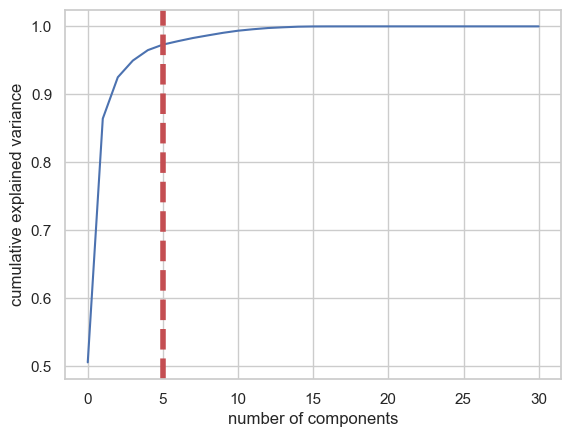

   Cumulative Variance Ratio  Explained Variance Ratio
0                   0.505919                  0.505919
1                   0.864312                  0.358393
2                   0.925178                  0.060866
3                   0.949700                  0.024522
4                   0.965068                  0.015368
#########t-SNE#########
The number of features after t-SNE:  3
KL divergence:  0.20073963701725006


In [12]:
# PCA
print("#########PCA#########")
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print('The number of features after PCA: ', pca.n_components_)
Train_pca = DataFrame(X_train_pca)
Train_pca.insert(0, 'Date', Train_date.values)
Test_pca = DataFrame(X_test_pca)
Test_pca.insert(0, 'Date', Test_date.values)
Train_pca.to_csv('./FE results/Train_pca.csv')
Test_pca.to_csv('./FE results/Test_pca.csv')
# plot
pca_all = PCA(n_components=31)
pca_all.fit(X_train_scaled)
evr = pca_all.explained_variance_ratio_
cvr = np.cumsum(evr)
sns.set(style='whitegrid')
plt.plot(cvr)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle='--', x=pca.n_components_, ymin=0, ymax=1)
plt.show()
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
print(pca_df.head(pca.n_components_))

# t-SNE
print("#########t-SNE#########")
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)
print('The number of features after t-SNE: ', X_train_tsne.shape[1])
print('KL divergence: ', tsne.kl_divergence_)
Train_tsne = DataFrame(X_train_tsne)
Train_tsne.insert(0, 'Date', Train_date.values)
Test_tsne = DataFrame(X_test_tsne)
Test_tsne.insert(0, 'Date', Test_date.values)
Train_tsne.to_csv('./FE results/Train_tsne.csv')
Test_tsne.to_csv('./FE results/Test_tsne.csv')

